In [1]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [2]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import toytree
import tqdm
from matplotlib import pyplot as plt
import torch
import copy
from converter import pdbgraph
import foldtree2_ecddcd as ft2
import importlib
from src import foldseek2tree
importlib.reload(ft2)


In [ ]:
#change the modelname to the one you want to load
modelname = 'small5_geo_graph'
with open( modelname + '.pkl', 'rb') as f:
	encoder, decoder = pickle.load(f)


/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
print( encoder)
print( decoder)

mk1_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_contactPoints_res): GATv2Conv(857, 300, heads=8)
      (res_hbond_res): GATv2Conv(857, 300, heads=8)
    )
    (1): ModuleDict(
      (res_contactPoints_res): GATv2Conv(300, 300, heads=8)
      (res_hbond_res): GATv2Conv(300, 300, heads=8)
    )
  )
  (norms): ModuleList(
    (0-1): 2 x LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  )
  (bn): BatchNorm1d(857, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.001, inplace=False)
  (jk): JumpingKnowledge(cat)
  (lin): Sequential(
    (0): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=600, out_features=300, bias=True)
  )
  (out_dense): Sequential(
    (0): Linear(in_features=320, out_features=400, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=400, out_features=20, bia

In [6]:
print( encoder.num_embeddings)

40


In [7]:
datadir = '../../datasets/'
model_dir = 'models/'

outdir_base = '../../results/foldtree2/'

if not os.path.exists(outdir_base):
	os.makedirs(outdir_base)

#output for matrices 
matdir = outdir_base + 'matrices/'
if not os.path.exists(matdir):
	os.makedirs(matdir)

#output for trees
treedir = outdir_base + 'trees/'
if not os.path.exists(treedir):
	os.makedirs(treedir)

In [8]:
#read the afdb rep file
reps = pd.read_table( datadir + 'afdbclusters/1-AFDBClusters-entryId_repId_taxId.tsv', header=None, names=['entryId', 'repId', 'taxId'] )
print( 'reps' , reps.head() )

reps       entryId       repId    taxId
0  A0A009E921  A0A009E921  1310605
1  A0A009F5K6  A0A009E921  1310605
2  A0A009E9H3  A0A009E9H3  1310605
3  A0A484ZLT0  A0A009E9H3    82979
4  A0A009ECR5  A0A009ECR5  1310605


In [9]:
repdirs = '../../datasets/foldtree2/struct_align/'

In [10]:
mkdirs = False
if mkdirs == True:
	#make a structure alignment directory
	if not os.path.exists( 'struct_align' ):
		os.makedirs( 'struct_align' )
	
	#make a directory for each cluster representative
	for rep in reps['repId']:
		if not os.path.exists( datadir +'struct_align/' + rep  ):
			os.makedirs(datadir + 'struct_align/' + rep  )
		if not os.path.exists( datadir+ 'struct_align/' + rep  + '/structs/'):
			os.makedirs( datadir+ 'struct_align/' + rep + '/structs/' )
			

In [11]:
#download n struct members for each cluster
dl_structs = False
if dl_structs == True:
	n = 5
	for rep in tqdm.tqdm(reps.repId.unique() ):
		subdf = reps[ reps['repId'] == rep ]
		if len(subdf) < n:
			n = len(subdf)
		subdf = subdf.sample( n = n  )
		subdf = subdf.head( n )
		#download the structures
		for uniID in subdf['entryId']:
			AFDB_tools.grab_struct(uniID , structfolder=datadir+'struct_align/' + rep  + '/structs/')

In [12]:
#for each folder in struct_align, align the structures with all vs all using foldseek
aln_structs = False
if aln_structs == True:
	for rep in tqdm.tqdm(reps.repId.unique() ):
		#align the structures
		foldseek2tree.runFoldseek_allvall_EZsearch( infolder= datadir + 'struct_align/' + rep  + '/structs/', outpath=datadir+'struct_align/' + rep + '/allvall.csv' )


In [4]:
#get all example structures in a directory
structs = glob.glob('families/fsx1/*.pdb')


In [14]:

converter = pdbgraph.PDB2PyG()

In [15]:
ndim = 844
alphabetsize = encoder.vector_quantizer.embedding_dim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#device = torch.device('cpu')
print(device)

encoder = encoder.to(device)
decoder = decoder.to(device)
encoder.eval()

cuda:0


mk1_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_contactPoints_res): GATv2Conv(857, 300, heads=8)
      (res_hbond_res): GATv2Conv(857, 300, heads=8)
    )
    (1): ModuleDict(
      (res_contactPoints_res): GATv2Conv(300, 300, heads=8)
      (res_hbond_res): GATv2Conv(300, 300, heads=8)
    )
  )
  (norms): ModuleList(
    (0-1): 2 x LayerNorm((300,), eps=1e-05, elementwise_affine=True)
  )
  (bn): BatchNorm1d(857, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.001, inplace=False)
  (jk): JumpingKnowledge(cat)
  (lin): Sequential(
    (0): LayerNorm((600,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=600, out_features=300, bias=True)
  )
  (out_dense): Sequential(
    (0): Linear(in_features=320, out_features=400, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=400, out_features=400, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=400, out_features=20, bia

In [16]:
from torch_geometric.data import DataLoader
struct_dat = pdbgraph.StructureDataset('structalignmk4.h5')
#struct_dat = ft2.StructureDataset('structs_training.h5')
encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=False)
#encode the structures
encode_alns = True
if encode_alns == True:
	def databatch2list(loader):
		for data in loader:
			data = data.to_data_list()
			for d in data:
				d = d.to(device)
				yield d
	encoder_loader = databatch2list(encoder_loader)
	encoder.encode_structures_fasta(encoder_loader , modelname+'_aln_encoded.fasta' )

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
12530it [10:08, 20.59it/s]


In [17]:
encoded_fasta = modelname+'_aln_encoded.fasta' 
seqstr = ''
ID = ''
seqdict = {}
with open(encoded_fasta, 'r') as f:
	#read all chars of file into a string
	for line in tqdm.tqdm(f):
		if line[0] == '>' and line[-1] == '\n':
			seqdict[ID] = seqstr
			ID = line[1:].strip()
			seqstr = ''
		else:
			seqstr += line.strip()
del seqdict['']
encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#change index to protid
encoded_df.index = encoded_df.protid
encoded_df = encoded_df.drop( 'protid', axis=1 )

print(encoded_df)

125572it [00:00, 970825.03it/s]

                                                          seq
protid                                                       
A0A009NC05  ("&$(("'$(!''...
A0A011NNG3  !!"!'""!!!!...
A0A011P981 \t!&!"!&" !''!&&...
A0A011Q6F0  %&\t# #$#\t&...
A0A011TX23  &&""!'"'...
...                                                       ...
X8C4D9      %"!"!" !&"!!...
X8CW14      &'!!\t%""!!...
X8F2F7      \t"&" """"...
X8IXX3      &&%%&&&...
X8JSL8      %%&'"...

[12529 rows x 1 columns]


In [18]:
charset = 249
#make fasta is shifted by 1 and goes from 1-248 included
#0x01 – 0xFF excluding > (0x3E), = (0x3D), < (0x3C), - (0x2D), Space (0x20), Carriage Return (0x0d) and Line Feed (0x0a)
#replace 0x22 or " which is necesary for nexus files and 0x23 or # which is also necesary

replace_dict = {chr(0):chr(246) , '"':chr(248) , '#':chr(247), '>' : chr(249), '=' : chr(250), '<' : chr(251), '-' : chr(252), ' ' : chr(253) , '\r' : chr(254), '\n' : chr(255) }
rev_replace_dict = { v:k for k,v in replace_dict.items() }

replace_dict_ord = { ord(k):ord(v) for k,v in replace_dict.items() }
rev_replace_dict_ord = { ord(v):ord(k) for k,v in replace_dict.items() }

print(replace_dict)
print(rev_replace_dict)

print( replace_dict_ord )

print(rev_replace_dict_ord)

{'\x00': 'ö', '"': 'ø', '#': '÷', '>': 'ù', '=': 'ú', '<': 'û', '-': 'ü', ' ': 'ý', '\r': 'þ', '\n': 'ÿ'}
{'ö': '\x00', 'ø': '"', '÷': '#', 'ù': '>', 'ú': '=', 'û': '<', 'ü': '-', 'ý': ' ', 'þ': '\r', 'ÿ': '\n'}
{0: 246, 34: 248, 35: 247, 62: 249, 61: 250, 60: 251, 45: 252, 32: 253, 13: 254, 10: 255}
{246: 0, 248: 34, 247: 35, 249: 62, 250: 61, 251: 60, 252: 45, 253: 32, 254: 13, 255: 10}


In [19]:
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))


In [20]:
#embedding starts at 0
encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
#hex starts at 1
encoded_df['hex2'] = encoded_df.ord.map( lambda x: [ hex(c) for c in x] )


In [21]:
print( encoded_df)

                                                          seq  \
protid                                                          
A0A009NC05  (ø&$((ø'$(!''...   
A0A011NNG3  !!ø!'øø!!!!...   
A0A011P981 \t!&!ø!&øý!''!&&...   
A0A011Q6F0  %&\t÷ý÷$÷\t&...   
A0A011TX23  &&øø!'ø'...   
...                                                       ...   
X8C4D9      %ø!ø!øý!&ø!!...   
X8CW14      &'!!\t%øø!!...   
X8F2F7      \tø&øýøøøø...   
X8IXX3      &&%%&&&...   
X8JSL8      %%&'ø...   

                                                          ord  \
protid                                                          
A0A009NC05  [40, 7, 8, 19, 248, 11, 7, 38, 25, 36, 20, 1

In [22]:
#find union of all sets of characters for sequences
char_set = set()
for seq in encoded_df.seq:
	char_set = char_set.union( set( seq ) )

print( char_set )
print( len(char_set) )
ordset = set()
for ords in encoded_df.ord:
	ordset = ordset.union( set( ords ) )
print( ordset )
print( len(ordset) )

with open('char_set.pkl', 'wb') as f:
	pickle.dump(char_set, f)

char_set = list( char_set )
char_set.sort()
print( char_set )
print( len(char_set) )


{'\x0c', '\x03', '\x16', '\x1f', '\x1e', '$', '\x1c', '\x0f', '\x13', 'ý', '\x0b', '\x02', '\x1b', '\x0e', 'ø', '\x05', '\x15', '\x07', '\x17', '\x08', '\x10', '\t', '\x11', "'", '\x18', '\x14', '\x1a', '\x1d', '\x19', '%', '\x04', '&', '÷', '(', '\x06', '!', '\x01', '\x12'}
38
{1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 36, 37, 38, 39, 40, 247, 248, 253}
38
['\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08', '\t', '\x0b', '\x0c', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x14', '\x15', '\x16', '\x17', '\x18', '\x19', '\x1a', '\x1b', '\x1c', '\x1d', '\x1e', '\x1f', '!', '$', '%', '&', "'", '(', '÷', 'ø', 'ý']
38


In [23]:
cols = 'query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,qaln,taln'.split(',')
alnfiles = glob.glob(datadir + 'struct_align/*/allvall.csv')
fident_thresh = .3
submat =  np.zeros((256,256))
background_freq = np.zeros(len(char_set))
q_mat = np.zeros((256,256))
seqcount = 0


In [28]:

for rep in tqdm.tqdm(alnfiles ):
	q_mat_chunk = np.zeros((256,256))
	submat_chunk = np.zeros((256,256))
	alncount = 0
	#load the all vs all aln
	aln_df = pd.read_table(rep)
	aln_df.columns = cols
	#load the embedding of the structures
	q = aln_df['query'].unique()
	t = aln_df['target'].unique()
	
	seqset = set()
	representative = rep.split('/')[-2]
	for q in aln_df['query'].unique():
		for t in aln_df['target'].unique():
			if q != t:
				#align the structures
				aln = aln_df[ (aln_df['query'] == q) & (aln_df['target'] == t) ]
				if len(aln)> 0 and aln.fident.iloc[0] < fident_thresh:
					aln = aln.iloc[0]
					qaln = aln.qaln
					taln = aln.taln
					qaccession = q.split( '.' )[0]
					taccession = t.split( '.' )[0]

					if qaccession in encoded_df.index and taccession in encoded_df.index:
						qz = str(encoded_df.loc[qaccession].seq[aln.qstart-1:aln.qend])
						tz = str(encoded_df.loc[taccession].seq[aln.tstart-1:aln.tend])

						if qaccession not in seqset:
							background_freq += np.array([ qz.count( c ) for c in char_set ])
							seqset.add( qaccession )
							seqcount += len(qz)
							
						if taccession not in seqset:
							background_freq += np.array([ tz.count( c ) for c in char_set ])
							seqset.add( taccession )
							seqcount += len(tz)
						

						if len( qz) == len( qaln.replace('-','') ) and len( tz) == len( taln.replace('-','') ):
							qz = iter(qz)
							tz = iter(tz)

							#transfer the alignments to the embeddings                    
							qaln_ft2, taln_ft2 = [], []

							for q_char in qaln:
								if q_char == '-':
									qaln_ft2.append(None)
								else:
									qaln_ft2.append(ord(next(qz)))
								   
							for t_char in taln.strip():
								if t_char == '-':
									taln_ft2.append(None)
								else:
									taln_ft2.append(ord(next(tz)))

							alnzip = list(zip( qaln_ft2 , taln_ft2 ))
							alnzip = np.array([ [a[0] , a[1]] for a in alnzip if a[0] is not None and a[1] is not None])
							#normalize by size of alignment
							
							submat_chunk[alnzip[:,0] , alnzip[:,1]] += 1
							#normalize by size of alignment and number of pairs
							alncount += 1
							q_mat_chunk[alnzip[:,0] , alnzip[:,1]] += 1 / len(qaln.replace('-',''))
		if alncount > 0:
			submat += (submat_chunk / alncount)

100%|█| 3691/3691 [00:36<0


In [29]:
ordset = np.array(list(ordset))
print(ordset)

[  1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  33  36  37  38  39  40 247
 248 253]


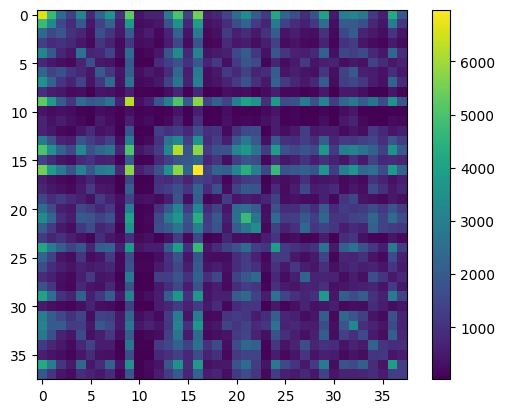

In [30]:
mafft_mat = submat[ordset , :] 
mafft_mat = mafft_mat[ : , ordset ]
mafft_mat = (mafft_mat + mafft_mat.T) / 2
plt.imshow(mafft_mat)
plt.colorbar()


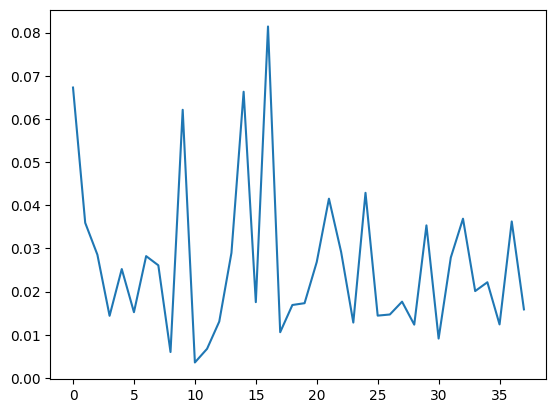

In [32]:
plt.plot( background_freq / sum(background_freq) )

In [33]:
import numpy as np

def compute_log_odds_from_counts(
	pair_counts: np.ndarray,
	char_freqs: np.ndarray,
	pseudocount: float = 1e-20,
	log_base: float = np.e
) -> np.ndarray:
	"""
	Computes a log-odds ratio matrix from a pair-count matrix and a vector of character frequencies.

	Parameters
	----------
	pair_counts : np.ndarray (n x n)
		pair_counts[i, j] = number of times character i is aligned with character j.
	char_freqs : np.ndarray (n,)
		char_freqs[i] = background frequency of character i.
	pseudocount : float
		Small value added to avoid division by zero.
	log_base : float
		Base of the logarithm (np.e for natural log, 2 for log base 2, 10 for log base 10, etc.).

	Returns
	-------
	log_odds_matrix : np.ndarray (n x n)
		log_odds_matrix[i, j] = log-odds ratio for substituting character i with character j.
	"""

	# 1. Validate input dimensions
	n = pair_counts.shape[0]
	if pair_counts.shape[1] != n:
		raise ValueError("pair_counts must be an n x n matrix.")
	if char_freqs.shape[0] != n:
		raise ValueError("char_freqs must have length n.")

	# 2. Compute total sum of pair counts (for normalization)
	total_pairs = np.sum(pair_counts)

	# 3. Compute observed frequencies with pseudocount
	#    obs_freq[i, j] = (pair_counts[i, j] + pseudocount) / (total_pairs + pseudocount_factor)
	#    You can scale pseudocount_factor as you see fit; for simplicity, we'll just add pseudocount to numerator
	obs_freq = (pair_counts + pseudocount) / (total_pairs + pseudocount * (n**2))

	# 4. Compute expected frequencies using background frequencies
	#    exp_freq[i, j] = char_freqs[i] * char_freqs[j]
	#    Note: if your background frequencies do not sum to 1, you may need to normalize them first
	char_freqs = char_freqs / np.sum(char_freqs)
	exp_freq = np.outer(char_freqs, char_freqs) + pseudocount

	# 5. Compute log-odds ratio
	#    ratio[i, j] = obs_freq[i, j] / exp_freq[i, j]
	ratio =    obs_freq / exp_freq 

	#    log_odds[i, j] = log(ratio[i, j]) / log(log_base)
	#    We add a small epsilon to avoid log(0.0) if ratio < 1e-15, etc.
	epsilon = 1e-15
	plt.imshow(ratio)
	plt.colorbar()
	plt.show()
	log_odds_matrix = np.log(ratio + epsilon) / np.log(log_base)

	return log_odds_matrix


In [41]:

def compute_raxml_compatible_matrix(pair_counts, char_freqs, pseudocount=1e-20, log_base=np.e, scaling_factor=1.0):
    # Compute the log odds matrix as you already do
    log_odds_matrix = compute_log_odds_from_counts(pair_counts, char_freqs, pseudocount, log_base)
    
    # Exponentiate the log odds to get relative rates
    preliminary_rates = np.exp(log_odds_matrix * scaling_factor)
    
    # Symmetrize the matrix to ensure reversibility
    n = preliminary_rates.shape[0]
    rate_matrix = np.zeros_like(preliminary_rates)
    for i in range(n):
        for j in range(n):
            if i != j:
                rate_matrix[i, j] = (preliminary_rates[i, j] + preliminary_rates[j, i]) / 2.0
    # Set diagonal entries so that each row sums to zero
    for i in range(n):
        rate_matrix[i, i] = -np.sum(rate_matrix[i, :]) + rate_matrix[i, i]
    
    # Scale the matrix so that the expected substitution rate is 1
    # Calculate the expected rate: sum_i πᵢ * (-Qᵢᵢ)
    char_freqs = char_freqs / np.sum(char_freqs)
    expected_rate = -np.sum(char_freqs * np.diag(rate_matrix))
    rate_matrix = rate_matrix / expected_rate

    return rate_matrix , char_freqs

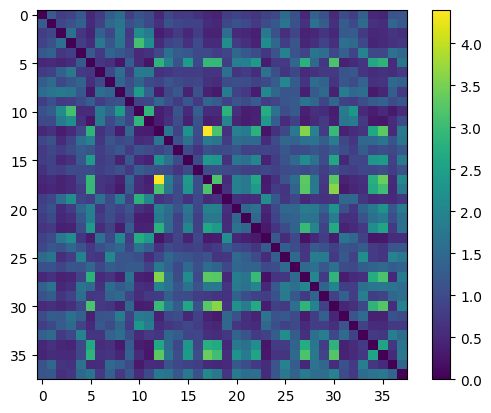

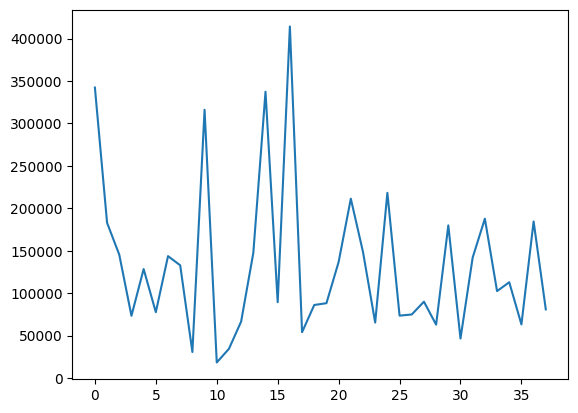

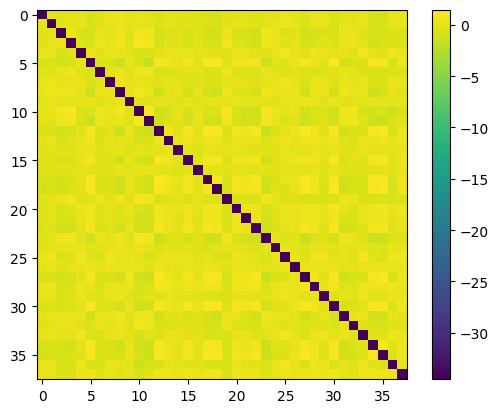

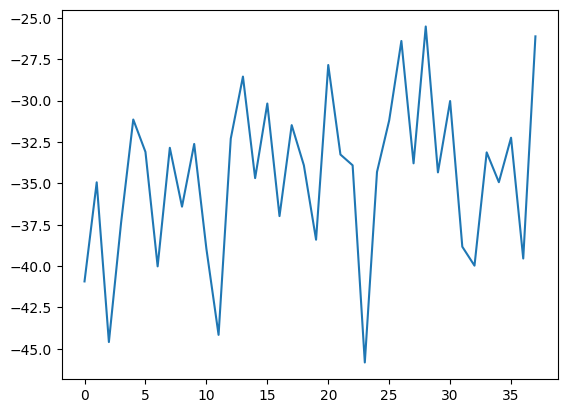

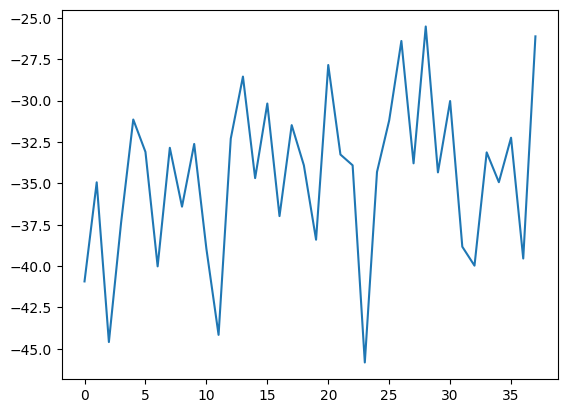

5089006.0
[[6.14160078e-19 7.72638498e-04 4.91960267e-04 ... 2.80858209e-04
  6.94088035e-04 7.07768375e-04]
 [7.72638498e-04 6.14160080e-19 5.89904572e-04 ... 3.54953524e-04
  8.91773340e-04 7.39429889e-04]
 [4.91960267e-04 5.89904572e-04 6.14160082e-19 ... 3.20544196e-04
  4.03412607e-04 3.77520248e-04]
 ...
 [2.80858209e-04 3.54953524e-04 3.20544196e-04 ... 6.14160103e-19
  3.30119565e-04 1.08619592e-03]
 [6.94088035e-04 8.91773340e-04 4.03412607e-04 ... 3.30119565e-04
  6.14160080e-19 8.80066908e-04]
 [7.07768375e-04 7.39429889e-04 3.77520248e-04 ... 1.08619592e-03
  8.80066908e-04 6.14160093e-19]]


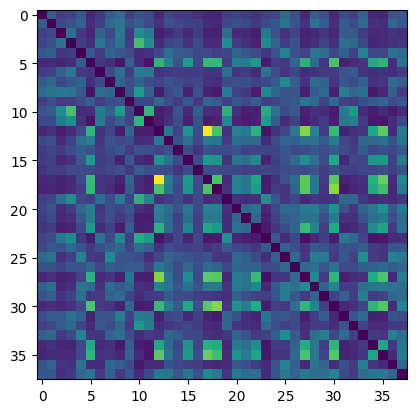

In [42]:
import copy
mafft_mat_count = copy.deepcopy(mafft_mat)
np.fill_diagonal(mafft_mat_count, 0)
#mafft_mat_count = mafft_mat_count / np.sum(mafft_mat_count)
log_odds = compute_log_odds_from_counts(mafft_mat_count, background_freq )
plt.plot( background_freq  )
plt.show()
plt.imshow(log_odds)
plt.colorbar()
plt.show()
plt.plot(np.sum(log_odds , axis= 0) )
plt.show()
plt.plot(np.sum(log_odds , axis= 1) )
plt.show()
print( np.sum( background_freq ) )

#exponential of log odds
submat = np.exp(log_odds)
submat = (submat + submat.T) / 2
submat = submat / np.sum(submat)
plt.imshow(submat)
print( submat )

In [43]:
ords = np.array([ ord(c) for c in char_set ])
ords_original = ords.copy()
ords_original = sorted([ i if i not in rev_replace_dict_ord else rev_replace_dict_ord[i] for i in ords ])
print(ords)
print( ords_original)


[  1   2   3   4   5   6   7   8   9  11  12  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  33  36  37  38  39  40 247
 248 253]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [ ]:
#raxml mat
inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~""".split()
revmap_raxml = { c:ords[i] for i,c in enumerate(inputchars[:len(char_set)]) }
map_raxml = { ords[i]:c for i,c in enumerate(inputchars[:len(char_set)]) }
raxml_alphabet = inputchars[:len(char_set)]


<>:3: SyntaxWarning: invalid escape sequence '\ '
<>:3: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_3071891/1942585402.py:3: SyntaxWarning: invalid escape sequence '\ '
  inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~""".split()


In [46]:
#mafft matrix file example max 248 char

"""
0x01 0x01 2   # (comment)
0x1e 0x1e 2
0x1f 0x1f 2
0x21 0x21 2   # ! × !
0x41 0x41 2   # A × A
0x42 0x42 2   # B × B
0x43 0x43 2   # C × C
"""

def formathex(hexnum):
	if len(hexnum) == 3:
		return hexnum[0:2] + '0' + hexnum[2]
	else:
		return hexnum

def output_mafft_matrix( submat , char_set ,  outpath='mafft_submat.mtx' ):
	print( submat.shape , len( char_set ) )
	with open(outpath, 'w') as f:
		for i in range(len(char_set)):
			for j in range(len(char_set)):
				if i <= j:
					stringi = char_set[i]
					stringj = char_set[j]
					
					if stringi in replace_dict.keys():
						stringi = replace_dict[stringi]
					if stringj in replace_dict.keys():
						stringj = replace_dict[stringj]
				  
					hexi = formathex(hex(ord(stringi)))
					hexj = formathex(hex( ord(stringj)))
					
					f.write( f'{hexi} {hexj} {submat[i,j]} \n ')# '+ stringi + 'x' + stringj + ' \n' )
				   
output_mafft_matrix( mafft_mat , char_set= char_set,  outpath=modelname+'_mafft_submat.mtx' )
print(modelname+'_mafft_submat.mtx')

(38, 38) 38
small5_geo_graph_mafft_submat.mtx


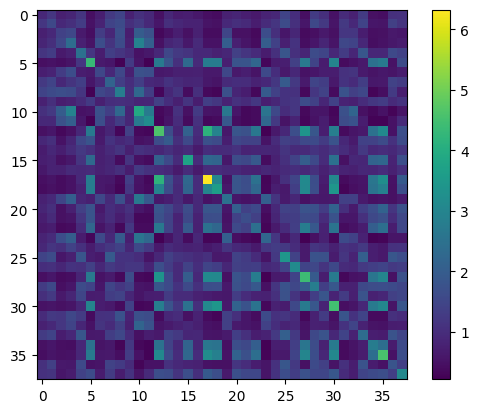

small5_geo_graphraxml_custom_matrix.txt


 0.031013

 0.019747 0.023678

 0.021731 0.027036 0.039566

 0.029875 0.033680 0.016969 0.020001

 0.012328 0.013461 0.011281 0.014114 0.030677

 0.019036 0.021328 0.033826 0.043127 0.018261 0.017320

 0.031904 0.037508 0.023485 0.029213 0.035020 0.014879 0.023889

 0.037897 0.041528 0.043664 0.041768 0.030071 0.006510 0.039262 0.035230

 0.019957 0.026686 0.018256 0.019850 0.024924 0.032607 0.019226 0.026261 0.027095

 0.027352 0.031991 0.052145 0.076332 0.013203 0.014378 0.044772 0.034942 0.059602 0.021801

 0.023874 0.024026 0.045238 0.053965 0.015677 0.005827 0.043699 0.023935 0.034204 0.022624 0.071197

 0.012529 0.015332 0.008636 0.012717 0.023071 0.070407 0.015768 0.021994 0.008492 0.035903 0.009255 0.008353

 0.023215 0.026740 0.013409 0.022068 0.039491 0.047200 0.017313 0.028789 0.023475 0.026447 0.012736 0.014754 0.042553

 0.017838 0.023557 0.018829 0.024967 0.031679 0.027636 0.019699 0.024730 0.029456 0.019482 0.027988 0.025565 0.02

In [48]:
def raxml_matrix( matrix, background_frequencies, outfile = modelname+"_raxml_custom_matrix.txt"):
	# Create the substitution matrix file
	#lower triangular matrix
	with open(outfile, "w") as f:
		for i in range(matrix.shape[0]):
			for j in range(matrix.shape[0]):
				if j < i:
					#format to 6 decimal places
					f.write(f" {matrix[i,j]:.6f}")
			f.write("\n")
		# Add the frequencies
		for i, freq in enumerate(background_frequencies):
			f.write(f"{freq:.6f} ")
		f.write("\n")
	return outfile

submat, bg = compute_raxml_compatible_matrix( mafft_mat, background_freq, pseudocount=1e-20, log_base=np.e, scaling_factor=1.0)
outmatrix = raxml_matrix( submat , bg,  outfile = modelname+"raxml_custom_matrix.txt")
print(outmatrix)
with open(modelname+"raxml_custom_matrix.txt", 'r') as f:
	for line in f:
		print(line)

In [169]:
#align the structures
# mafft --textmatrix maff_submat.mtx input > output

In [170]:
import subprocess
import Bio.PDB as PDB
def run_mafft_textaln( infasta , outaln , matrix='mafft_submat.mtx' ):
	cmd = f'mafft --text --localpair --maxiterate 1000 --textmatrix {matrix} {infasta}  > {outaln}'
	print(cmd)
	subprocess.run(cmd, shell=True)
	return outaln

def mafft_hex2fasta( intext , outfasta ):
	#% /usr/local/libexec/mafft/hex2maffttext input.hex > input.ASCII
	cmd = f'/usr/lib/mafft/lib/mafft/hex2maffttext {intext} > {outfasta}'
	print(cmd)
	subprocess.run(cmd, shell=True)
	return outfasta    


def fasta2hex( intext , outfasta ):
	#% /usr/local/libexec/mafft/maffttext2hex input.hex > input.ASCII
	cmd = f'/usr/lib/mafft/lib/mafft/maffttext2hex {intext} > {outfasta}'
	print(cmd)
	subprocess.run(cmd, shell=True)
	return outfasta    

def normal_mafft( infasta , outaln ):
	cmd = f'mafft --anysymbol {infasta} > {outaln}'
	print(cmd)
	subprocess.run(cmd, shell=True)
	return outaln



def struct2sequence(structfile):
	parser = PDB.PDBParser()
	structure = parser.get_structure('struct', structfile)
	seq = ''
	for model in structure:
		for chain in model:
			for residue in chain:
				if PDB.is_aa(residue):
					seq += residue.get_resname()
	return seq

In [55]:
import glob
structs = glob.glob('families/fsx1/*.pdb')


In [56]:
#make normal fasta
with open( 'fsx1_example.fasta', 'w') as f:
	for s in structs:
		seq =  struct2sequence(s)
		if len(seq)>0:
			identifier = s.split('/')[-1].split('.')[0]
			f.write('>' + identifier + '\n' + seq + '\n')


/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 9706
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record ' ' at line 19
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3009
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 3774
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 6559
  warnings.warn(
/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/Bio/PDB/PDBParser.py:384: PDBConstructionWarning: Ignoring unrecogniz

In [57]:

def loader( structlist , converter):
	for struct in tqdm.tqdm(structlist):
		try:
			data = converter.struct2pyg( struct )
			if data:
				yield data
		except:
			print('error')
			continue
loader = loader( structs , converter )
encoder.encode_structures_fasta( loader , 'fsx1_encoded.fasta')


1it [00:01,  1.50s/it]

error


100%|███████████████████████| 18/18 [00:20<00:00,  1.14s/it]
17it [00:20,  1.21s/it]


'fsx1_encoded.fasta'

In [58]:
#load the encoded fasta
with open('fsx1_encoded.fasta') as encoded:
	seqstr = '' 
	ID = ''
	seqdict = {}
	for line in encoded:
		if line[0] == '>' and line[-1] == '\n':
			seqdict[ID] = seqstr
			ID = line[1:].strip()
			seqstr = ''
		else:
			seqstr += line.strip()
	del seqdict['']
	encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#replace the characters that aren't allowed
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))
encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
print(encoded_df.head())

#write output to fasta
with open('fsx1_encoded_replaced.fasta', 'w') as f:
	for idx, row in encoded_df.iterrows():
		f.write('>' + row.protid + '\n' + row.seq + '\n')
 

                 protid                                                seq  \
0        fsxA11_monomer  ÷÷(÷('$÷÷÷'÷&...   
1                  4GSX  &÷ý÷÷&÷÷÷&...   
2  WP_049937247_Hnatans  &&('&(&÷&((÷&÷&÷%...   
3            4OJC_model  $'&\t÷&÷&((&÷&...   
4                  4HJ1  '&÷÷(÷%÷÷&&%&&%...   

                                                 ord  
0  [25, 25, 27, 24, 22, 23, 4, 3, 21, 247, 18, 27...  
1  [19, 19, 2, 4, 19, 24, 21, 28, 3, 22, 1, 38, 2...  
2  [38, 38, 38, 8, 30, 26, 40, 25, 1, 3, 21, 21, ...  
3  [21, 15, 36, 3, 3, 26, 21, 39, 21, 19, 38, 3, ...  
4  [39, 24, 15, 17, 23, 3, 22, 4, 27, 38, 1, 1, 1...  


In [59]:
#convert fsx1_encoded.fasta to fsx1_encoded.hex
encoded_fasta = 'fsx1_encoded_replaced.fasta'
with open(encoded_fasta, 'r') as f:
	#read all chars of file into a string
	with open('fsx1_encoded.hex' , 'w') as g:
		for line in f:
			if line[0] == '>':
				g.write(line )
			else:
				hexstr = ''
				for char in line:
					o = ord(char)
					if o in replace_dict_ord:
						o = replace_dict_ord[o]
					hexstr += formathex(hex(o))[2:] + ' '
				g.write(hexstr + '\n')

with open( 'fsx1_encoded.hex', 'r') as f:
	for line in f:
		print(line)

>fsxA11_monomer

19 19 1b 18 16 17 04 03 15 f7 12 1b 18 17 1a 16 1a 1e 17 f7 28 f7 28 27 03 24 13 18 04 1c f7 16 f7 f7 1e 1e 03 27 15 18 f7 03 06 18 26 04 18 26 04 1a 01 18 02 1e 27 1d 19 1b 19 17 13 1e 17 13 1e 1e 01 21 f7 01 0f 25 1e 18 1e 03 04 1e 02 15 1b 1a 1f 03 1a 16 26 f7 0f 26 1e 04 18 19 0f 18 03 04 15 f7 26 1a 26 03 16 1b 26 18 1a f7 04 1b 17 26 f7 16 08 27 26 18 f7 1c f7 18 24 18 17 1a 04 17 fd 19 19 16 18 26 28 03 0f 03 19 08 13 1c 04 26 16 1e 08 19 18 15 03 13 04 1a 06 08 1e 03 18 1e 1a f7 15 04 18 26 1e 18 16 1d 04 18 fd 06 27 f7 1e f7 26 01 03 1c 03 18 03 16 1c 1f f7 18 26 1f 06 26 1c 03 03 26 08 28 01 f7 f7 18 16 1c 1f 26 1a 1c 1a 18 17 17 16 18 f7 17 15 1c 1e 18 f7 0f 03 16 16 17 1e 0f 17 15 f7 1c 1e 1c 27 26 03 19 04 03 25 f7 1a 0f f7 18 0f 27 04 04 17 f7 17 17 f7 03 04 1a 03 18 03 f7 1c 02 26 f7 1c 03 1f 21 18 03 03 15 17 13 24 17 17 02 03 15 17 04 1c 18 18 1b 19 f7 1a 26 03 17 1c f7 1e 17 15 18 1c 26 15 17 28 25 28 01 03 17 1a 03 04 17 17 02 f7 15 03 25 19 25 03 17

In [60]:
#go to ascii encoding
hexfile = 'fsx1_encoded.hex'
asciifile = mafft_hex2fasta( hexfile , 'fsx1_encoded.ASCII' )

/usr/lib/mafft/lib/mafft/hex2maffttext fsx1_encoded.hex > fsx1_encoded.ASCII


In [61]:
#align wti mafft
textaln = run_mafft_textaln( asciifile , 'fsx1_encoded_aln.ascii' , matrix='mafft_submat.mtx' )

mafft --text --localpair --maxiterate 1000 --textmatrix mafft_submat.mtx fsx1_encoded.ASCII  > fsx1_encoded_aln.ascii


outputhat23=16
treein = 0
compacttree = 0
stacksize: 8192 kb
nalphabets = 256
nused=
All-to-all alignment.
tbfast-pair (text) Version 7.526
alg=L, model=Extended, 2.00, -0.10, +0.10, noshift, amax=0.0
0 thread(s)

outputhat23=16
Loading 'hat3.seed' ... 
done.
Writing hat3 for iterative refinement
nalphabets = 256
nused=
Gap Penalty = -1.53, +0.00, +0.00
tbutree = 1, compacttree = 0
Constructing a UPGMA tree ... 
   10 / 16
done.

Progressive alignment ... 
STEP    10 /15 
Reallocating..done. *alloclen = 2027
STEP    15 /15 
done.
tbfast (text) Version 7.526
alg=A, model=Extended, 1.53, -0.00, -0.00, noshift, amax=0.0
1 thread(s)

minimumweight = 0.000010
autosubalignment = 0.000000
nthread = 0
randomseed = 0
blosum -2 / kimura 200
poffset = 0
niter = 16
sueff_global = 0.100000
nadd = 16
Loading 'hat3' ... done.
nalphabets = 256
nused=

   10 / 16
Segment   1/  1    1- 820
STEP 011-013-1  identical.    accepted. accepted. identical.    accepted. accepted. accepted. accepted. accepted. a

In [62]:
#change from mafft text 2 hex
aln_hexfile = fasta2hex( textaln, 'fsx1_encoded.aln.hex' )


/usr/lib/mafft/lib/mafft/maffttext2hex fsx1_encoded_aln.ascii > fsx1_encoded.aln.hex


In [63]:

with open( aln_hexfile , 'r') as f:
	for l in f:
		print(l)

>fsxA11_monomer

19 19 1b 18 -- -- 16 -- -- -- 17 04 03 15 f7 12 1b 18 17 1a -- 16 1a -- 1e 17 f7 28 f7 28 -- 27 03 -- -- -- -- -- -- -- -- 24 13 18 04 1c f7 16 -- -- -- -- -- -- -- f7 -- -- -- f7 

-- 1e 1e -- -- 03 27 15 -- 18 f7 03 -- -- -- -- -- -- -- -- -- -- 06 -- -- -- -- -- 18 26 -- 04 18 26 04 -- -- -- -- -- -- 1a -- -- -- -- 01 18 02 1e 27 1d -- -- 19 1b 19 17 13 1e 

17 13 1e 1e 01 21 f7 01 0f 25 1e 18 1e 03 04 -- -- -- -- 1e 02 -- -- -- -- -- -- 15 -- -- 1b 1a -- -- -- 1f 03 1a -- -- -- -- -- 16 -- -- -- 26 f7 -- -- -- -- 0f -- -- -- -- 26 1e 

04 18 19 0f 18 03 -- -- -- -- 04 15 f7 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 26 -- -- -- 1a -- 26 -- -- -- -- -- 03 -- -- 16 -- -- -- -- -- -- -- -- -- -- -- -- -- 

-- -- -- 1b -- -- -- -- -- 26 -- -- -- -- 18 -- -- -- -- 1a f7 -- -- -- -- 04 -- -- -- -- -- -- -- -- -- 1b 17 -- -- 26 f7 16 08 27 -- -- -- -- -- 26 -- -- 18 f7 1c -- -- -- -- f7 

-- -- -- -- 18 -- -- 24 18 17 1a -- -- 04 17 fd 19 -- -- -- 19 16 18 -- 2

In [64]:
#read the aln hex file
with open( aln_hexfile , 'r') as f:
	seqdict = {}
	seqstr = ''
	ID = ''
	for line in f:
		if line[0] == '>':
			seqdict[ID] = seqstr
			ID = line[1:].strip()
			seqstr = ''
		else:
			seqstr += line + ' '
	seqdict[ID] = seqstr
alndf = pd.DataFrame( seqdict.items() , columns=['protid', 'hex_aln'] )
alndf.index = alndf.protid
alndf.drop( 'protid' , axis = 1 , inplace = True)
alndf.drop( ''  , inplace = True)
alndf['ord_aln'] = alndf.hex_aln.map( lambda x: [ int(c,16) if c!='--' else '-' for c in x.split() ] )
alndf['seq_aln'] = alndf.ord_aln.map( lambda x: ''.join([ chr(c) if c !='-' else '-' for c in x ]) )
print(alndf)

                                                                   hex_aln  \
protid                                                                       
fsxA11_monomer           19 19 1b 18 -- -- 16 -- -- -- 17 04 03 15 f7 1...   
4GSX                     -- -- -- 13 -- -- 13 -- -- -- 02 04 13 -- -- -...   
WP_049937247_Hnatans     -- -- -- 26 -- -- 26 -- -- -- -- 26 08 1e 1a 2...   
4OJC_model               -- -- -- 15 -- -- 0f -- -- -- 24 03 03 -- 1a 1...   
4HJ1                     -- -- 27 18 -- -- 0f -- -- -- 11 17 03 16 04 1...   
WP_058826362_Haloferax   -- -- -- f7 -- -- f7 -- -- -- 1c f7 1e -- 03 2...   
6EGU                     -- 02 02 17 -- -- -- -- -- -- -- -- 03 16 04 1...   
WP_007110832_Naltunense  -- -- -- 04 -- -- 04 -- -- -- -- f7 03 1e f7 2...   
3n43                     -- -- -- 03 12 1c f7 -- -- -- 1c 04 0f 1f f7 -...   
5mf1mono                 -- -- -- 04 -- -- -- -- -- -- -- -- 26 08 13 2...   
1rer                     -- -- -- 03 -- -- 10 -- -- -- 08 f7 0f 

In [65]:
#re-encode to 64 char
remap = { c:i for i,c in enumerate(char_set)}
print(remap)

{'\x01': 0, '\x02': 1, '\x03': 2, '\x04': 3, '\x05': 4, '\x06': 5, '\x07': 6, '\x08': 7, '\t': 8, '\x0b': 9, '\x0c': 10, '\x0e': 11, '\x0f': 12, '\x10': 13, '\x11': 14, '\x12': 15, '\x13': 16, '\x14': 17, '\x15': 18, '\x16': 19, '\x17': 20, '\x18': 21, '\x19': 22, '\x1a': 23, '\x1b': 24, '\x1c': 25, '\x1d': 26, '\x1e': 27, '\x1f': 28, '!': 29, '$': 30, '%': 31, '&': 32, "'": 33, '(': 34, '÷': 35, 'ø': 36, 'ý': 37}


In [66]:
alndf['remap_int'] = alndf.seq_aln.map(lambda x : [ remap[c] if c in remap else '-' for c in x ] )

#NEXUS
inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~"""

symbols = {i:s for i,s in enumerate( inputchars.split() ) }
print( len( symbols) )
alndf['remap_symbols'] = alndf['remap_int'].map( lambda x : ''.join([ symbols[c] if c in symbols else '-' for c in x ]) )
print(alndf.remap_symbols)

64
protid
fsxA11_monomer             MMOL--J---K32IZFOLKN-JN-RKZYZY-X2--------UGL3P...
4GSX                       ---G--G---13G------L-IP-2J0WZ"--P---------LPPJ...
WP_049937247_Hnatans       ---W--W----W7RNYM02I-IX-2PJOWYSIW---------ZLN3...
4OJC_model                 ---I--C---U22-NIXIGW-2C-C81KN-------------ZC3P...
4HJ1                       --XL--C---EK2J3OW00G-3Z-ZEYZ2-VSZ---------N1GJ...
WP_058826362_Haloferax     ---Z--Z---PZR-2YMYLI-IL-OPJOZ0SIWZLN3SPRQY27N3...
6EGU                       -11K--------2J3OWKKG-3Z-Z1YZ----Z---------N1GJ...
WP_007110832_Naltunense    ---3--3----Z2RZYM02I-IX-2PIP3-------------MR3L...
3n43                       ---2FPZ---P3CSZ----C-RN-ZJPMG-------------CKCJ...
5mf1mono                   ---3--------W7GU2N1P-PXVZ-22JL1O2---------NPPP...
1rer                       ---2--D---7ZCMI----C-RN-W832G-------------C7CJ...
2ala                       ---2--D---KZCMI----C-RN-WF32G-------------CKCJ...
2I69                       ---I--IS14KSGLIJ2YWZ"PL-JPJ2LK1PZ------

In [67]:
#output remap symbols column to fasta
with open('fsx1_encoded.aln.remap.fasta', 'w') as f:
	for i in alndf.index:
		f.write('>' + i + '\n' + alndf.loc[i].remap_symbols + '\n')


In [ ]:
def raxml_matrix( matrix, background_frequencies, outfile = "raxml_custom_matrix.txt"):
	# Create the substitution matrix file
	#lower triangular matrix
	with open(outfile, "w") as f:
		for i in range(matrix.shape[0]):
			for j in range(matrix.shape[0]):
				if j < i:
					#format to 6 decimal places
					f.write(f" {matrix[i,j]:.6f}")
			f.write("\n")
		# Add the frequencies
		for i, freq in enumerate(background_frequencies):
			f.write(f"{freq:.6f} ")
		f.write("\n")
	return outfile

print(sub_raxml.shape)

bg_raxml = background_freq
sub_raxml = log_odds

outmatrix = raxml_matrix( sub_raxml , background_freq,  outfile = "raxml_custom_matrix.txt")

with open('raxml_custom_matrix.txt', 'r') as f:
	for line in f:
		print(line)

(38, 38)


 -29.281512

 -29.232207 -29.199286

 -29.223250 -29.181851 -29.554527

 -29.034086 -29.214579 -29.171025 -29.266291

 -28.963460 -29.147027 -29.256239 -29.270914 -29.087558

 -28.763714 -29.766166 -29.079996 -29.652255 -29.124251 -29.581926

 -29.001218 -29.106707 -29.264985 -29.130109 -29.150500 -28.973579 -31.537947

 -29.147020 -28.551223 -29.283010 -29.113711 -28.836776 -28.806283 -29.994090 -29.177446

 -28.856947 -29.049019 -29.124737 -29.049631 -29.737782 -28.577671 -30.495606 -28.864021 -29.430115

 -28.775492 -28.764011 -28.453521 -29.224356 -28.623829 -28.784539 -34.536274 -29.060961 -34.538468 -29.196525

 -28.830757 -31.348132 -28.657737 -28.848597 -34.537139 -27.923482 -34.507955 -28.055214 -34.534926 -34.536495 -34.502547

 -29.348497 -29.175635 -29.632430 -29.552184 -29.001348 -29.536689 -28.785093 -29.376162 -28.961146 -29.340466 -28.635269 -29.231546

 -29.113072 -28.804474 -29.255572 -29.049275 -29.004821 -28.947299 -29.138169 -28.940868 -28.339174 -28.950

In [70]:
#raxml cmd using subprocess
import subprocess
def run_raxml_ng(fasta_file, matrix_file, nsymbols, output_prefix , iterations = 20 ):
	raxml_cmd ='./raxml-ng  --model MULTI'+str(nsymbols)+'_GTR{'+matrix_file+'}+I+G --redo  --all --bs-trees '+str(iterations)+' --seed 12345 --threads 8 --msa '+fasta_file+' --prefix '+output_prefix 
	print(raxml_cmd)
	subprocess.run(raxml_cmd, shell=True)
	return None


def run_raxml_ng_normal(fasta_file, output_prefix, iterations = 20):
	raxml_cmd ='./raxml-ng  --model LG+I+G  --redo --all --bs-trees ' +str(iterations)+' --seed 12345 --threads 8 --msa '+fasta_file+' --prefix '+output_prefix 
	print(raxml_cmd)
	subprocess.run(raxml_cmd, shell=True)
	return None


#ancestral reconstruction
#raxml-ng --ancestral --msa ali.fa --tree best.tre --model HKY --prefix ASR

def run_raxml_ng_ancestral_struct(fasta_file, tree_file, matrix_file, nsymbols, output_prefix):
	model = 'MULTI'+str(nsymbols)+'_GTR{'+matrix_file+'}+I+G'
	raxml_cmd ='./raxml-ng  --redo --ancestral --msa '+fasta_file+' --tree '+tree_file+' --model '+model+' --prefix '+output_prefix 
	print(raxml_cmd)
	subprocess.run(raxml_cmd, shell=True)
	return None

def run_raxml_ng_ancestral_normal(fasta_file, tree_file, model = 'LG+I+G', output_prefix='ASR'):
	raxml_cmd ='./raxml-ng  --ancestral --msa '+fasta_file+' --tree '+tree_file+' --model '+model+' --prefix '+output_prefix 
	print(raxml_cmd)
	subprocess.run(raxml_cmd, shell=True)
	return None

def madroot( treefile  ):
	mad_cmd = f'./madroot/mad {treefile} '
	print(mad_cmd)
	subprocess.run(mad_cmd, shell=True)
	return treefile+'.rooted'

In [71]:

run_raxml_ng('fsx1_encoded.aln.remap.fasta'  ,'raxml_custom_matrix.txt' , len(char_set) , 'fsx1_example' )


./raxml-ng  --model MULTI38_GTR{raxml_custom_matrix.txt}+I+G --redo  --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_encoded.aln.remap.fasta --prefix fsx1_example

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 12-Feb-2025 00:22:22 as follows:

./raxml-ng --model MULTI38_GTR{raxml_custom_matrix.txt}+I+G --redo --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_encoded.aln.remap.fasta --prefix fsx1_example

Analysis options:
  run mode: ML tree search + bootstrapping (Felsenstein Bootstrap)
  start tree(s): random (10) + parsimony (1

In [72]:
run_raxml_ng_ancestral_struct(fasta_file='fsx1_encoded.aln.remap.fasta', tree_file= 'fsx1_example.raxml.bestTree', matrix_file='raxml_custom_matrix.txt', nsymbols=len(char_set), output_prefix='ancestral_1st')

./raxml-ng  --redo --ancestral --msa fsx1_encoded.aln.remap.fasta --tree fsx1_example.raxml.bestTree --model MULTI38_GTR{raxml_custom_matrix.txt}+I+G --prefix ancestral_1st

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: Intel(R) Xeon(R) Silver 4110 CPU @ 2.10GHz, 16 cores, 251 GB RAM

RAxML-NG was called at 12-Feb-2025 00:32:27 as follows:

./raxml-ng --redo --ancestral --msa fsx1_encoded.aln.remap.fasta --tree fsx1_example.raxml.bestTree --model MULTI38_GTR{raxml_custom_matrix.txt}+I+G --prefix ancestral_1st

Analysis options:
  run mode: Ancestral state reconstruction
  start tree(s): user
  random seed: 1739316747
  tip-inner: O

In [75]:
#turn the ancestral state file into a fasta

def ancestral2fasta( ancestral_file , outfasta ):
	with open( outfasta , 'w') as g:        
		with open( ancestral_file , 'r') as f:
			for l in f:
				words = l.split('	')
				if len(words) == 2:
					identifier, seq = words
					g.write('>' + identifier + '\n' + seq + '\n')
	return outfasta

outfasta = ancestral2fasta('ancestral_1st.raxml.ancestralStates' , 'ASR.ancestral.fasta' )
with open(outfasta, 'r') as f:
	for l in f:
		print(l)    


>Node1

WWWZWWZWWWPZRRNYMY2IWILWOPJOZ0SIWZLN3SPRQY27N32KWPCK7722K3AZWYWWWPWWTL2CIWJWWQWWCW3WCWWWZIWLPKJKVKDOSZWGLRWNCWRCJK5XZNKWWGWWWW3W2HXWPNNZVKKN52QHL"ZZWWZMWWW1PLWWZMXWWWWZLW2WWZPLVWZZLP12WGW2XWWNKHRXRHZKRMROWI1WWWWWWWWGWGML"IWL11ZHCOWWWWWWWLWZIWWRWWWWWNWWWWR77ELZ3R1"OGWJLWLIWWLMLJOWPWS3WWKCX2F1PIGWWWXZL"I82X3"GJJWWWLWNSCOZPP"3ZXZZW7S4GRWXWNPK"2KJKZ2MWWCCWQFMMRVLPL72RWIWWWRXSR!SJ8Y3LRWWWWWW2WWWGP3W5W7I2WWLIRJLWWW2KGR07R57IV5SSW4WSRLLJJ2!WWWWJZWWWZ2Y9WJ2YN2MNW22WWRYW2ICQZMWE7KCJKWWWKLY2W3JLKKI5MWWWWWWWWWWWWINJLXKL2GWWCWWKWWJKLC2IKPRPLWWWWW2WOWWWZ3KNCVNWWC23PKOFZKW28KI2JK5G3KP2W2WWW2LMVWLK2KICKWWWWWOWWWWIKZWKPGZKEY5LKE2RIKOKJOLZOWWGPWWKCZWKIKIGPZZWZZZ7ZOKWIKWWWWWWWZO1K2ZP22XKPWWZ0K2P7ZKPKPZ10WWWWYWWWZO2L2WWNKKWEZ2L23NNWWWWW2NMWWWW45TOM2ZPWWWLP3K1ZMWJNJ2OLNWWWWPWW2PE0WL1KWLU22WWWGWR3K5IKLPLPWOR21GWWZOWWWN1XX



>Node2

M1K3FP3S14P32KNYMY2N"IXVZPJ2Z01IZZLN3SPRQYNPPJ2JOPCK772ZK3PZO235OPX2TLCCIKJK1QS0CLC1C10EL3W2PKZKVKDOS21GLJWWCRRWPKKCJN1J1GRR0T302LVCRNNZVKKR52QHL"ZZS"NZ8881ZLWWGG1WWWWZ

In [76]:
#read the probabilities into a dataframe$
probdf = pd.read_csv('ancestral_1st.raxml.ancestralProbs', sep = '\t')
print(probdf.head())

ParserError: Error tokenizing data. C error: EOF inside string starting at row 5384

In [77]:
#transform the fasta to a dataframe
aln_data = {}
with open(outfasta, 'r') as f:
	for line in f:
		if line[0] == '>':
			ID = line[1:].strip()
			aln_data[ID] = ''
		else:
			aln_data[ID] += line.strip()
ancestral_df = pd.DataFrame( aln_data.items() , columns=['protid', 'seq'] )
#use rev map to convert back to ord
ancestral_df['ord'] = ancestral_df.seq.map( lambda x: [ revmap_raxml[c] if c in revmap_raxml else '-' for c in x ] )

print(ancestral_df)

print( ancestral_df.ord.iloc[0])

    protid                                                seq  \
0    Node1  WWWZWWZWWWPZRRNYMY2IWILWOPJOZ0SIWZLN3SPRQY27N3...   
1    Node2  M1K3FP3S14P32KNYMY2N"IXVZPJ2Z01IZZLN3SPRQYNPPJ...   
2    Node3  M1KKFPGS1413G42S2Y2L"IPVZPJ2Z"1PZZLN3SPRQYNPPJ...   
3    Node4  M1KKFPGS1413G4NY2Y2L"IPVZPJ2Z01PZZLN3SPRQYNPPJ...   
4    Node5  M1K3FPGS14P32RNY2Y2L"IXVZPJ2Z01IZZLN3SPRQYNPPJ...   
5    Node6  WWW2WP2WWWP3W7GU2N1PWPXVZP22JL1O2ZWN3WWWWWNPPP...   
6    Node7  M1O2FP2S14P327ZY202P"IXVZP22ZL1OZZLN3SPRQUNPPJ...   
7    Node8  WWW2FPDWWWKZCMIY202CWRNVWF32GW1WZWWWWWWWWWCKCJ...   
8    Node9  WWW2FPDWWWP3CMZY202CWRNVZ832G01OZZWN3WWWWWCKCJ...   
9   Node10  M1O2FPCS14P327ZY202C"IXVZPJ2Z01OZZLN3SPRQUNPPJ...   
10  Node11  M1O3FPCS14P32RNY20KN"IXVZPJ2Z01OZZLN3SPRQUNPPJ...   
11  Node12  MMOLFPCS14K32IZFOLKN"INVZ8Z2ZY1XZZLN3SPRQUNP3P...   
12  Node13  M1OLFPCS14P32JZY20KN"IXVZPJ2Z01SZZLN3SPRQUNPPJ...   
13  Node14  W11LWWCWWWEK2J3OW0KGW3ZWZ1YZ20VSZZWWWWWWWWN1GJ...   

                        

In [78]:
#import pytorch geometric hetero data
from torch_geometric.data import HeteroData 
from scipy import sparse

#map each of the characters from raxml to the embedding 
def get_backbone(naa):
	backbone_mat = np.zeros((naa, naa))
	backbone_rev_mat = np.zeros((naa, naa))
	np.fill_diagonal(backbone_mat[1:], 1)
	np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
	return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
	sparsemat = sparse.find(sparsemat)
	return np.vstack([sparsemat[0],sparsemat[1]])

def ancestral_reconstruction2aa( ords , verbose = False):
	encoder.eval()
	decoder.eval()
	
	ords = torch.tensor(ords).to(device)
	z = encoder.vector_quantizer.embeddings( ords  )
	edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ] ).T
	#generate a backbone for the decoder
	data = HeteroData()
	backbone, backbone_rev = get_backbone( z.shape[0] )
	backbone = sparse.csr_matrix(backbone)
	backbone_rev = sparse.csr_matrix(backbone_rev)
	backbone = sparse2pairs(backbone)
	backbone_rev = sparse2pairs(backbone_rev)
	data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
	data['res','backbonerev','res'].edge_index = torch.tensor(backbone_rev,  dtype=torch.long )
	data = data.to( device )
	recon_x, edge_probs = decoder(z , edge_index , data.edge_index_dict )
	
	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	if verbose == True:
		print( recon_x )
		print( edge_probs )
	aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
	return aastr ,edge_probs

#ancestral_df['aa_reconstruction']= ancestral_df.ord.map( lambda x: ancestral_reconstruction2aa( x  ) )
aatest,edgeprobs = ancestral_reconstruction2aa( ancestral_df.ord.iloc[2] , verbose = True)
print(aatest)
plt.imshow(np.log(1-edgeprobs.detach().cpu().numpy()))  
plt.colorbar()
plt.show()
plt.imshow(1-edgeprobs.detach().cpu().numpy())  
plt.colorbar()
plt.show()


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [79]:
print(converter.aaindex)
revmap_aa = { i:c for i,c in enumerate(converter.aaindex) }
print(revmap_aa)

{'A': 0, 'C': 4, 'D': 3, 'E': 6, 'F': 13, 'G': 7, 'H': 8, 'I': 9, 'K': 11, 'L': 10, 'M': 12, 'N': 2, 'P': 14, 'Q': 5, 'R': 1, 'S': 15, 'T': 16, 'V': 19, 'W': 17, 'Y': 18}
{0: 'A', 1: 'C', 2: 'D', 3: 'E', 4: 'F', 5: 'G', 6: 'H', 7: 'I', 8: 'K', 9: 'L', 10: 'M', 11: 'N', 12: 'P', 13: 'Q', 14: 'R', 15: 'S', 16: 'T', 17: 'V', 18: 'W', 19: 'Y'}


In [340]:
aln = normal_mafft( 'fsx1_example.fasta' , 'fsx1_example.aln' )


mafft --anysymbol fsx1_example.fasta > fsx1_example.aln


inputfile = orig
17 x 2364 - 1152 p
nthread = 0
nthreadpair = 0
nthreadtb = 0
ppenalty_ex = 0
stacksize: 8192 kb
rescale = 1
Gap Penalty = -1.53, +0.00, +0.00



Making a distance matrix ..

There are 1404 ambiguous characters.
    1 / 17
done.

Constructing a UPGMA tree (efffree=0) ... 
   10 / 17
done.

Progressive alignment 1/2... 
STEP    13 / 16 
Reallocating..done. *alloclen = 5837
STEP    16 / 16 
done.

Making a distance matrix from msa.. 
    0 / 17
done.

Constructing a UPGMA tree (efffree=1) ... 
   10 / 17
done.

Progressive alignment 2/2... 
STEP    13 / 16 
Reallocating..done. *alloclen = 5803
STEP    16 / 16 
done.

disttbfast (aa) Version 7.453
alg=A, model=BLOSUM62, 1.53, -0.00, -0.00, noshift, amax=0.0
0 thread(s)


Strategy:
 FFT-NS-2 (Fast but rough)
 Progressive method (guide trees were built 2 times.)

If unsure which option to use, try 'mafft --auto input > output'.
For more information, see 'mafft --help', 'mafft --man' and the mafft page.

The default gap scori

In [341]:
with open('fsx1_example.aln' , 'r') as f:
	filestr= f.read()
	filestr = filestr.replace('U','A')
	filestr = filestr.replace('O','A')
	
with open('fsx1_example.aln' , 'w') as f:
	f.write(filestr)

In [342]:
#load alignment into dataframe
aln_data = {}
with open('fsx1_example.aln', 'r') as f:
	for line in f:
		if line[0] == '>':
			ID = line[1:].strip()
			aln_data[ID] = ''
		else:
			aln_data[ID] += line.strip()
normal_aln_df = pd.DataFrame( aln_data.items() , columns=['protid', 'seq'] )
print(normal_aln_df)
print(len(normal_aln_df.seq.iloc[0]))

                     protid                                                seq
0                      6EGA  ---------------CYSSERGLALEAILEGLNALASERSERARGI...
1                  5mf1mono  ---------VALILEALASERGL-YARGL--------------EAG...
2                      4GSX  ------------ARGCYSVALGLYILEGL---------YASNARGA...
3   WP_007110832_Naltunense  ---------------ILETHRGLATYRTHR------SERASNSERG...
4                4AJC_model  --------------GLYPHEP-RALEAGL---------------AG...
5                      2ala  ------------------TYRGL-AH--------------------...
6                      1AAN  ---------METARGCYSILEGLYILESE---------RASNARGA...
7                      2I69  ---------PHEASNCYSLEAGLYMETSE---------RASNARGA...
8                      6E18  ------GLAVALILEALASERGL-YARGL--------------EAG...
9      WP_049937247_Hnatans  ------------ALAALASER---TYRLYS------SERASNSERG...
10                     3n43  ------------GLYGLYTYRGL-AH--------------------...
11                     5ow3  ILEGLNILELEASERLYSSERLY

In [343]:
#run normal raxml on aln of protein sequence
run_raxml_ng_normal('fsx1_example.aln' , 'fsx1_example_normal' )

./raxml-ng  --model LG+I+G  --redo --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_example.aln --prefix fsx1_example_normal

RAxML-NG v. 1.2.2-master released on 30.04.2024 by The Exelixis Lab.
Developed by: Alexey M. Kozlov and Alexandros Stamatakis.
Contributors: Diego Darriba, Tomas Flouri, Benoit Morel, Sarah Lutteropp, Ben Bettisworth, Julia Haag, Anastasis Togkousidis.
Latest version: https://github.com/amkozlov/raxml-ng
Questions/problems/suggestions? Please visit: https://groups.google.com/forum/#!forum/raxml

System: 11th Gen Intel(R) Core(TM) i9-11900K @ 3.50GHz, 8 cores, 62 GB RAM

RAxML-NG was called at 02-Aug-2024 18:14:40 as follows:

./raxml-ng --model LG+I+G --redo --all --bs-trees 20 --seed 12345 --threads 8 --msa fsx1_example.aln --prefix fsx1_example_normal

Analysis options:
  run mode: ML tree search + bootstrapping (Felsenstein Bootstrap)
  start tree(s): random (10) + parsimony (10)
  bootstrap replicates: parsimony (20)
  random seed: 12345
  tip-inner: 

In [81]:
ft2_bs = 'fsx1_example.raxml.support'
#root the tree
madroot(ft2_bs)
#tre = toytree.tree(ft2_bs, format= 0)
#tre.draw(node_labels='support' ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= True )
tre = toytree.tree(ft2_bs+'.rooted')
#print the root node
root = tre.treenode.get_children()[0]
#get all leaf names

leaves = root.get_leaf_names()



tre = toytree.tree(ft2_bs, format= 0)
tre.root(names=leaves)

tre.draw( show_root=True ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= False,
	
	tip_labels_style={"font-size": "22px"},
	node_labels="support",
	node_labels_style={"font-size": "22px"},
	node_markers="r3x2",
	node_sizes=12,
	)
print(tre.get_tip_labels())

./madroot/mad fsx1_example.raxml.support 

MAD phylogenetic rooting

Analyzing file 'fsx1_example.raxml.support'...
>> [MAD=0.126_AI=0.975_CCV=16.4%_N=1/1]

Minimal ancestor deviation, MAD = 0.126
           Ambiguity index,  AI = 0.975
                  Clock CV, CCV = 16.4%
Rooted tree written to 'fsx1_example.raxml.support.rooted'


    - Please cite DOI:10.1038/s41559-017-0193



ValueError: invalid mode: 'rU'

In [347]:
ft2_bs = 'fsx1_example_normal.raxml.support'
tre = toytree.tree(ft2_bs)
#root the tree
madroot(ft2_bs)
#tre = toytree.tree(ft2_bs, format= 0)
#tre.draw(node_labels='support' ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= True )
tre = toytree.tree(ft2_bs+'.rooted')
#print the root node
root = tre.treenode.get_children()[0]
#get all leaf names

leaves = root.get_leaf_names()



tre = toytree.tree(ft2_bs, format= 0)
tre.root(names=leaves)

#make the tree face left

tre.draw( show_root=True ,  tip_labels_align=True, tip_labels_colors='r',  width=800, height=800 , scalebar= False,
	layout='l',
	tip_labels_style={"font-size": "22px"},
	node_labels="support",
	node_labels_style={"font-size": "22px"},
	node_markers="r3x2",
	node_sizes=12,
	
	)

print(tre.get_tip_labels())



./madroot/mad fsx1_example_normal.raxml.support 

MAD phylogenetic rooting

Analyzing file 'fsx1_example_normal.raxml.support'...
>> Warning: Trees with repeating branch lengths are suspicious (3 repeating values).
>> [MAD=0.062_AI=0.889_CCV=4.94%_N=1/1]

Minimal ancestor deviation, MAD = 0.062
           Ambiguity index,  AI = 0.889
                  Clock CV, CCV = 4.94%
Rooted tree written to 'fsx1_example_normal.raxml.support.rooted'


    - Please cite DOI:10.1038/s41559-017-0193

unrecognized arguments skipped: ['show_root']
check the docs, argument names may have changed.
['2ala', '1rer', '3n43', '6E18', '5mf1mono', 'WP_049937247_Hnatans', 'WP_058826362_Haloferax', 'fsxA11_monomer', 'WP_007110832_Naltunense', '4GSX', '1AAN', '2I69', '1SVB', '6EGA', '4HJ1', '5ow3', '4AJC_model']


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="800.0px" viewBox="0 0 800.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf288821e49c5429fbe9f654ad9fb8c61"> 100 85 100 100 100 85 100 100 100 100 100 50 80 100 2ala 1rer 3n43 6E18 5mf1mono WP_049937247_Hnatans WP_058826362_Haloferax fsxA11_monomer WP_007110832_Naltunense 4GSX 1AAN 2I69 1SVB 6EGA 4HJ1 5ow3 4AJC_model